In [1]:
# system information
import os
from glob import glob

# computing 
import numpy as np
import pandas as pd
from datetime import datetime
import scipy as sp
import scipy.optimize as op
import statistics 
import seaborn as sns
from random import uniform, seed, random
# plotting
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import gridspec
from matplotlib.ticker import AutoMinorLocator, MultipleLocator
%matplotlib inline

# ROOT files handling
from coffea.nanoevents import NanoEventsFactory, BaseSchema
import uproot as ur

In [28]:

sns.set(style = 'white')
mpl.rc('xtick.minor', visible = True)
mpl.rc('ytick.minor', visible = True)
mpl.rc('xtick', direction='in', top=True, bottom = True)
mpl.rc('ytick', direction='in', right=True, left = True)

# define ticks
def set_ticks(ax, xMaj, yMaj):
    ax.xaxis.set_major_locator(MultipleLocator(xMaj))
    ax.yaxis.set_major_locator(MultipleLocator(yMaj))
    ax.minorticks_on()
    ax.tick_params(which='major', width=1.0, length=8, direction='in', labelsize=14)
    ax.tick_params(which='minor', width=1.0, length=4, direction='in', labelsize=14)
    ax.yaxis.get_offset_text().set_fontsize(14)
    ax.xaxis.get_offset_text().set_fontsize(14)

In [3]:
params = np.array([0.02588903364201166, 0.0117937685867166])
cov_matrix = np.array([[ 4.25606075e-05, -4.81971726e-08],[-4.81971726e-08,  8.43411455e-11]])

a, b = params[0], params[1]
err_a, err_b = np.sqrt(cov_matrix[0,0]), np.sqrt(cov_matrix[1,1])
cov_ab = cov_matrix[0,1]


def propagate_err(x, sigma_x, a, b, cov_matrix):
    '''
        Propagate error considering TAC cal.
        input:  * x values in ADC
                * sigma_x in ADC
                * calibration parameters a,b 
                * covariance matrix 
        output: uncertainty on y values in us
    '''

    err_a, err_b = np.sqrt(cov_matrix[0,0]), np.sqrt(cov_matrix[1,1])
    cov_ab = cov_matrix[0,1]
    var_y = err_a**2 + err_b**2 * x**2 + 2 * cov_ab * x + b**2 * sigma_x**2
    return np.sqrt(var_y)

def ToADC(t, a, b):
    '''
        Function to convert time in us to ADC
    '''
    adc = (t - a)/ b
    return adc

def ToTime(adc, a, b):
    '''
        Function to convert time in ADC to us
    '''
    y = a + b * adc
    return y

In [83]:
t0 = ToTime(180.,a,b)
err_t0 = propagate_err(180, 0, a, b, cov_matrix)
err_t0

0.005286045637165839

In [90]:
1.26/np.exp(27*(1/tau_l_adc-1/tau_s_adc))

1.6038994024537254

In [4]:
## ---- Constants ---- ##
tau_short = 0.8466      # [us]
tau_long = 2.1969811    # [us]

tau_s_adc = ToADC(0.8466, a, b)
tau_l_adc = ToADC(2.1969811, a, b)

print("tau_short in ADC: %1.1f \ntau_long in ADC: %1.1f"%(tau_s_adc,tau_l_adc))

tau_short in ADC: 69.6 
tau_long in ADC: 184.1


In [5]:
tree4 = NanoEventsFactory.from_root('root_files/double_exp_3_new_norebin.root', schemaclass = BaseSchema, treepath='exp_4').events()
tree5 = NanoEventsFactory.from_root('root_files/double_exp_3_new_norebin.root', schemaclass = BaseSchema, treepath='exp_5').events()
tree6 = NanoEventsFactory.from_root('root_files/double_exp_3_new_norebin.root', schemaclass = BaseSchema, treepath='exp_6').events()
tree7 = NanoEventsFactory.from_root('root_files/double_exp_3_new_norebin.root', schemaclass = BaseSchema, treepath='exp_7').events()
tree8 = NanoEventsFactory.from_root('root_files/double_exp_3_new_norebin.root', schemaclass = BaseSchema, treepath='exp_8').events()
tree9 = NanoEventsFactory.from_root('root_files/double_exp_3_new_norebin.root', schemaclass = BaseSchema, treepath='exp_9').events()

In [6]:
matrix = np.zeros((6,10))


for i in range(0,10):
    matrix[0,i] = np.mean(np.nan_to_num(tree9.tau_plus[:,i]))
    matrix[1,i] = np.mean(np.nan_to_num(tree8.tau_plus[:,i]))
    matrix[2,i] = np.mean(np.nan_to_num(tree7.tau_plus[:,i]))
    matrix[3,i] = np.mean(np.nan_to_num(tree6.tau_plus[:,i]))
    matrix[4,i] = np.mean(np.nan_to_num(tree5.tau_plus[:,i]))
    matrix[5,i] = np.mean(np.nan_to_num(tree4.tau_plus[:,i]))

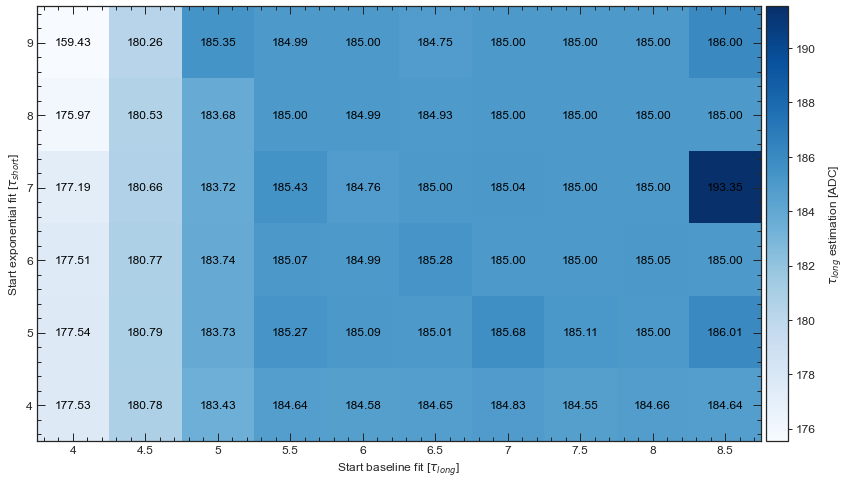

In [7]:
fig, ax = plt.subplots(figsize= (18,8))

max_, min_, mean_ = np.max(matrix), np.min(matrix), np.mean(matrix)
im = ax.imshow(matrix, cmap='Blues', vmin = mean_-8, vmax = mean_+8)

c = np.arange(4,9,0.5)

# Show all ticks and label them with the respective list entries
labelsx = ['4','4.5','5','5.5','6','6.5','7','7.5','8','8.5']
labelsy = ['9','8','7','6','5','4']

ax.set_xticks(np.arange(len(labelsx)), labels=labelsx)
ax.set_yticks(np.arange(len(labelsy)), labels=labelsy)

# Loop over data dimensions and create text annotations.
for i in range(len(labelsy)):
    for j in range(len(labelsx)):
        text = ax.text(j, i, '%1.2f'%matrix[i, j],
                       ha="center", va="center", color="black")

ax.set_xlabel('Start baseline fit [$\\tau_{long}$]', fontsize = 12)
ax.set_ylabel('Start exponential fit [$\\tau_{short}$]', fontsize = 12)

ax.tick_params(which='major', width=1.0, length=8, direction='in', labelsize=12)

cb = fig.colorbar(im, ax = ax, pad = 0.005)
cb.set_label(label = '$\\tau_{long}$ estimation [ADC]', fontsize = 12, labelpad=10)
cb.ax.tick_params(which='major', width=1.0, length=4, direction='out', labelsize=12)



plt.show()


In [8]:
matrix2 = np.zeros((6,10))

for i in range(0,10):
    matrix2[0,i] = 100*np.mean(np.nan_to_num(tree9.relerr_tau_plus[:,i][tree9.relerr_tau_plus[:,i] < 100]))
    matrix2[1,i] = 100*np.mean(np.nan_to_num(tree8.relerr_tau_plus[:,i][tree8.relerr_tau_plus[:,i] < 100]))
    matrix2[2,i] = 100*np.mean(np.nan_to_num(tree7.relerr_tau_plus[:,i][tree7.relerr_tau_plus[:,i] < 100]))
    matrix2[3,i] = 100*np.mean(np.nan_to_num(tree6.relerr_tau_plus[:,i][tree6.relerr_tau_plus[:,i] < 100]))
    matrix2[4,i] = 100*np.mean(np.nan_to_num(tree5.relerr_tau_plus[:,i][tree5.relerr_tau_plus[:,i] < 100]))
    matrix2[5,i] = 100*np.mean(np.nan_to_num(tree4.relerr_tau_plus[:,i][tree4.relerr_tau_plus[:,i] < 100]))

In [9]:
matrix = np.zeros((6,10))

for i in range(0,10):
    matrix[0,i] = 100*np.mean(np.nan_to_num(tree9.relerr_tau_minus[:,i][tree9.relerr_tau_minus[:,i] < 100]))
    matrix[1,i] = 100*np.mean(np.nan_to_num(tree8.relerr_tau_minus[:,i][tree8.relerr_tau_minus[:,i] < 100]))
    matrix[2,i] = 100*np.mean(np.nan_to_num(tree7.relerr_tau_minus[:,i][tree7.relerr_tau_minus[:,i] < 100]))
    matrix[3,i] = 100*np.mean(np.nan_to_num(tree6.relerr_tau_minus[:,i][tree6.relerr_tau_minus[:,i] < 100]))
    matrix[4,i] = 100*np.mean(np.nan_to_num(tree5.relerr_tau_minus[:,i][tree5.relerr_tau_minus[:,i] < 100]))
    matrix[5,i] = 100*np.mean(np.nan_to_num(tree4.relerr_tau_minus[:,i][tree4.relerr_tau_minus[:,i] < 100]))

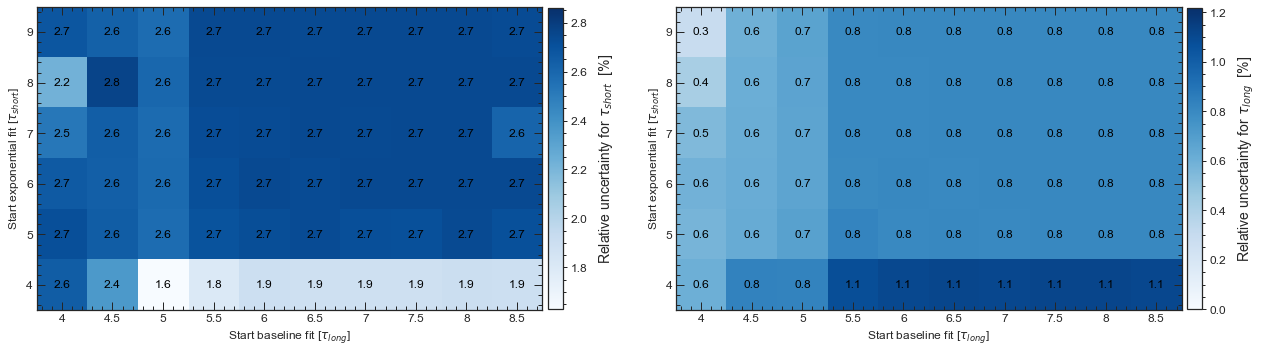

In [10]:
fig, ax = plt.subplots(1,2, figsize= (18,12))

max_, min_ = np.max(matrix), np.min(matrix)
im = ax[0].imshow(matrix, cmap='Blues', vmin = min_, vmax = max_+0.1)

# Show all ticks and label them with the respective list entries
labelsx = ['4','4.5','5','5.5','6','6.5','7','7.5','8','8.5']
labelsy = ['9','8','7','6','5','4']

ax[0].set_xticks(np.arange(len(labelsx)), labels=labelsx)
ax[0].set_yticks(np.arange(len(labelsy)), labels=labelsy)


# Loop over data dimensions and create text annotations.
for i in range(len(labelsy)):
    for j in range(len(labelsx)):
        text = ax[0].text(j, i, '%1.1f'%matrix[i, j],
                       ha="center", va="center", color="black",fontsize = 12)

ax[0].set_xlabel('Start baseline fit [$\\tau_{long}$]', fontsize = 12)
ax[0].set_ylabel('Start exponential fit [$\\tau_{short}$]', fontsize = 12)

ax[0].tick_params(which='major', width=1.0, length=8, direction='in', labelsize=12)

# Turn spines off and create white grid.
#ax[0].spines[:].set_visible(False)

cb = fig.colorbar(im, ax = ax[0],orientation = 'vertical', location = 'right', pad = 0.009, shrink =0.36)
cb.ax.set_ylabel('Relative uncertainty for $\\tau_{short}$  [%]', fontsize = 14, labelpad=10)
cb.ax.tick_params(which='major', width=1.0, length=4, direction='out', labelsize=12)
cb.ax.tick_params(which='minor', width=1.0, length=3, direction='out', labelsize=12)

cb.ax.minorticks_on()

#cb.ax[0].set_yticks(np.arange(0,0.06))

max_, min_ = np.max(matrix2), np.min(matrix2)
im = ax[1].imshow(matrix2, cmap='Blues', vmin = 0, vmax = max_+0.1)


# Show all ticks and label them with the respective list entries
labelsx = ['4','4.5','5','5.5','6','6.5','7','7.5','8','8.5']
labelsy = ['9','8','7','6','5','4']

ax[1].set_xticks(np.arange(len(labelsx)), labels=labelsx)
ax[1].set_yticks(np.arange(len(labelsy)), labels=labelsy)


# Loop over data dimensions and create text annotations.
for i in range(len(labelsy)):
    for j in range(len(labelsx)):
        text = ax[1].text(j, i, '%1.1f'%matrix2[i, j],
                       ha="center", va="center", color="black", fontsize = 12)

ax[1].set_xlabel('Start baseline fit [$\\tau_{long}$]', fontsize = 12)
ax[1].set_ylabel('Start exponential fit [$\\tau_{short}$]', fontsize = 12)

ax[1].tick_params(which='major', width=1.0, length=8, direction='in', labelsize=12)

# Turn spines off and create white grid.
#ax[1].spines[:].set_visible(False)

cb = fig.colorbar(im, ax = ax[1],orientation = 'vertical', location = 'right', pad = 0.009, shrink =0.36)
cb.ax.set_ylabel('Relative uncertainty for $\\tau_{long}$  [%]', fontsize = 14, labelpad=10)
cb.ax.tick_params(which='major', width=1.0, length=4, direction='out', labelsize=12)
cb.ax.tick_params(which='minor', width=1.0, length=3, direction='out', labelsize=12)

cb.ax.minorticks_on()

fig.tight_layout()
#fig.savefig("matrix.png", dpi = 400)
plt.show()


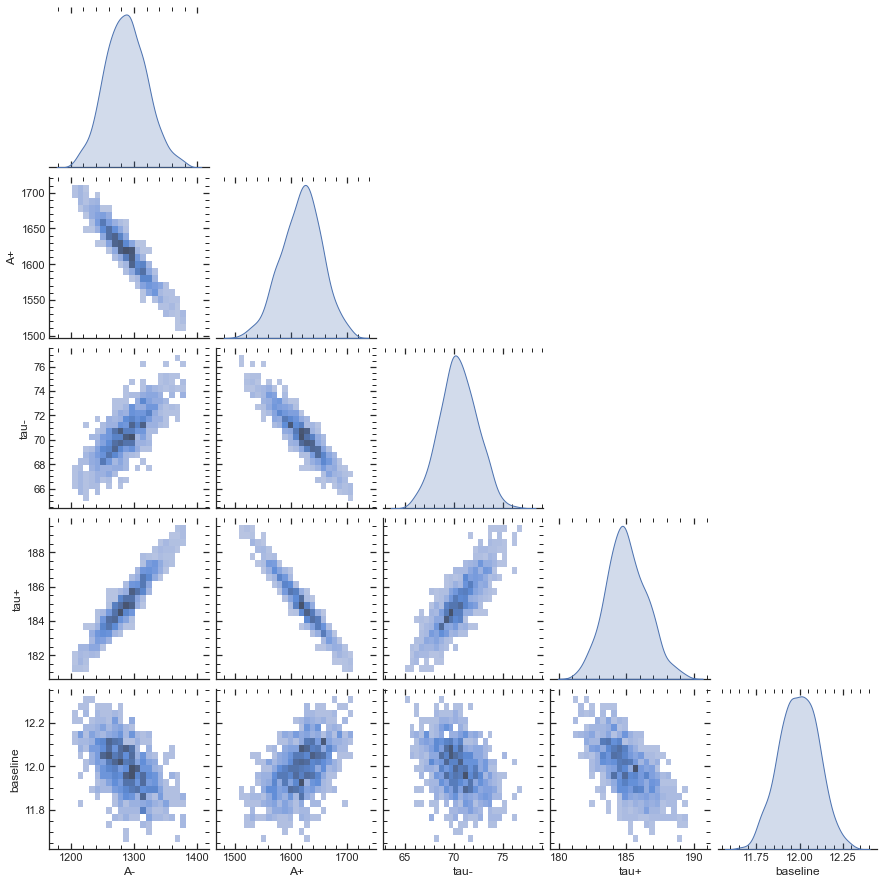

In [29]:
df = pd.DataFrame( tree6.A_minus[:,4], columns = ['A-'])
df['A+'] = tree6.A_plus[:,4]
df['tau-'] = tree6.tau_minus[:,4]
df['tau+'] = tree6.tau_plus[:,4]
df['baseline'] = tree6.bs[:,4]
df = df[df['A-'] > 1200]

#sns.set_palette("ch:s=.25,rot=-.25")

sns.pairplot(df, kind="hist", corner = True, diag_kind="kde")

In [292]:
mask = tree5.A_plus[:,4]/tree5.A_minus[:,4] > 0.7

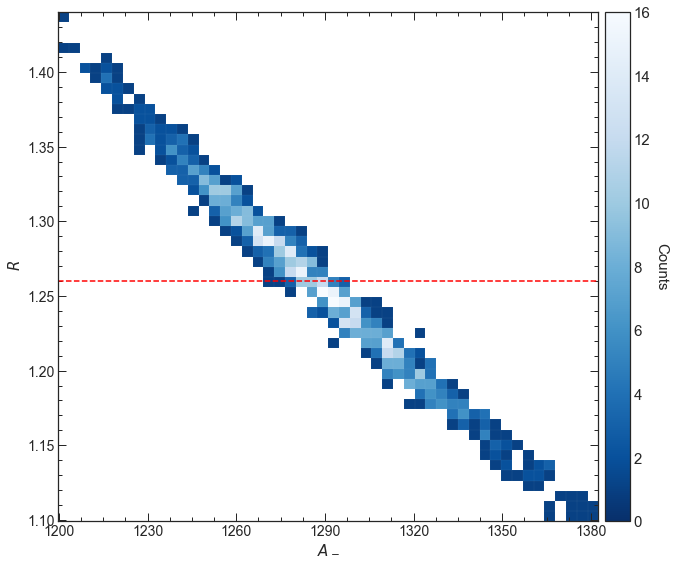

In [318]:
fig, ax = plt.subplots(figsize= (10,8))

x = tree5.A_minus[:,4][mask]
y = tree5.A_plus[:,4][mask]/tree5.A_minus[:,4][mask]

h, binx, biny, im = ax.hist2d(x,y, bins=50, density = False, cmap = 'Blues_r', vmin = 0, zorder = 0, cmin = 1)

for i in range(len(binx)):
    ax.axvline(binx[i], color = 'w', lw = 0.05, alpha = 1)

for i in range(len(biny)):
    ax.axhline(biny[i], color = 'w', lw = 0.05,  alpha = 1)


# labels
ax.set_xlabel('$A_-$', fontsize=15)
ax.set_ylabel(' $R$' , fontsize=15)

xg = np.linspace(np.min(x),np.max(x), 1000)
yg = 1.26*np.ones_like(xg)
ax.plot(xg,yg, ls = '--', c='red')

set_ticks(ax,30,0.05)

clb = fig.colorbar(im, ax=ax, pad = 0.01)
clb.ax.set_ylabel('Counts',fontsize = 15,rotation=270, labelpad=18)
clb.ax.tick_params(which='major', width=1.0, length=8, direction='in', labelsize=15)


fig.tight_layout()
fig.savefig('corrplot.png', dpi = 400)
plt.show()

#np.exp(20/tau_s_adc-20/tau_l_adc)


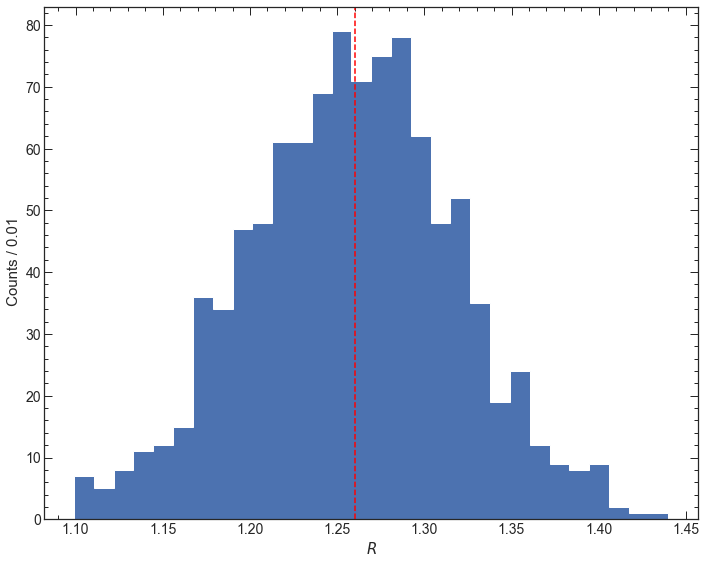

In [294]:
fig, ax = plt.subplots(figsize= (10,8))

h, bins, _ = ax.hist(y, bins = 30, histtype='stepfilled', color = 'b')

w = bins[1] - bins[0]

ax.axvline(1.26, ls = '--', color = 'red')

set_ticks(ax,0.05,10)

# labels
ax.set_xlabel('$R$', fontsize=15)
ax.set_ylabel(' Counts / %1.2f'%w , fontsize=15)

fig.tight_layout()
fig.savefig('R.png', dpi = 400)
plt.show()


In [302]:
matrix2 = np.zeros((6,10))

for i in range(0,10):
    matrix2[0,i] = np.mean(tree9.delta_A_plus[:,i][tree9.delta_A_plus[:,i] < 1000])
    matrix2[1,i] = np.mean(tree8.delta_A_plus[:,i][tree8.delta_A_plus[:,i] < 1000])
    matrix2[2,i] = np.mean(tree7.delta_A_plus[:,i][tree7.delta_A_plus[:,i] < 1000])
    matrix2[3,i] = np.mean(tree6.delta_A_plus[:,i][tree6.delta_A_plus[:,i] < 1000])
    matrix2[4,i] = np.mean(tree5.delta_A_plus[:,i][tree5.delta_A_plus[:,i] < 1000])
    matrix2[5,i] = np.mean(tree4.delta_A_plus[:,i][tree4.delta_A_plus[:,i] < 1000])

matrix = np.zeros((6,10))

for i in range(0,10):
    matrix[0,i] = np.mean(tree9.delta_A_minus[:,i][tree9.delta_A_minus[:,i] < 1000])
    matrix[1,i] = np.mean(tree8.delta_A_minus[:,i][tree8.delta_A_minus[:,i] < 1000])
    matrix[2,i] = np.mean(tree7.delta_A_minus[:,i][tree7.delta_A_minus[:,i] < 1000])
    matrix[3,i] = np.mean(tree6.delta_A_minus[:,i][tree6.delta_A_minus[:,i] < 1000])
    matrix[4,i] = np.mean(tree5.delta_A_minus[:,i][tree5.delta_A_minus[:,i] < 1000])
    matrix[5,i] = np.mean(tree4.delta_A_minus[:,i][tree4.delta_A_minus[:,i] < 1000])
    

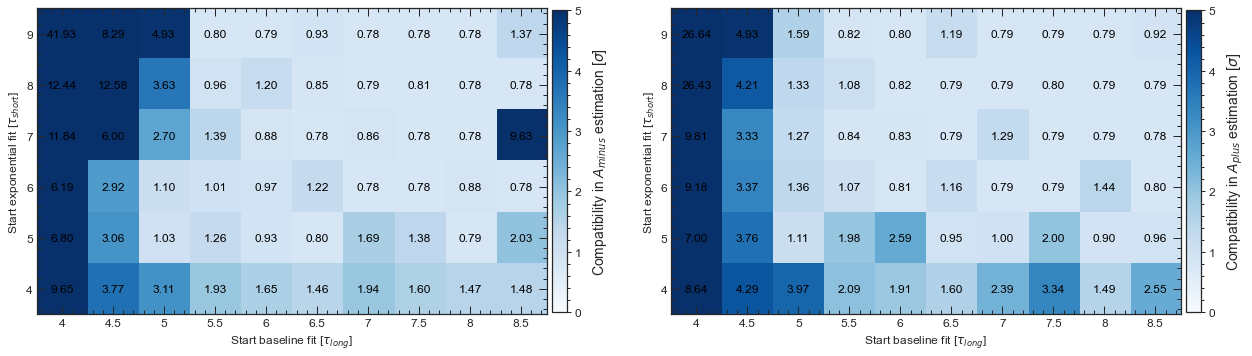

In [305]:
fig, ax = plt.subplots(1,2, figsize= (18,12))

max_, min_ = np.max(matrix), np.min(matrix)
im = ax[0].imshow(matrix, cmap='Blues', vmin = 0, vmax = 5)

# Show all ticks and label them with the respective list entries
labelsx = ['4','4.5','5','5.5','6','6.5','7','7.5','8','8.5']
labelsy = ['9','8','7','6','5','4']

ax[0].set_xticks(np.arange(len(labelsx)), labels=labelsx)
ax[0].set_yticks(np.arange(len(labelsy)), labels=labelsy)


# Loop over data dimensions and create text annotations.
for i in range(len(labelsy)):
    for j in range(len(labelsx)):
        text = ax[0].text(j, i, '%1.2f'%matrix[i, j],
                       ha="center", va="center", color="black",fontsize = 12)

ax[0].set_xlabel('Start baseline fit [$\\tau_{long}$]', fontsize = 12)
ax[0].set_ylabel('Start exponential fit [$\\tau_{short}$]', fontsize = 12)

ax[0].tick_params(which='major', width=1.0, length=8, direction='in', labelsize=12)

# Turn spines off and create white grid.
#ax[0].spines[:].set_visible(False)

cb = fig.colorbar(im, ax = ax[0],orientation = 'vertical', location = 'right', pad = 0.009, shrink =0.36)
cb.ax.set_ylabel('Compatibility in $A_{minus}$ estimation [$\sigma$]', fontsize = 14, labelpad=10)
cb.ax.tick_params(which='major', width=1.0, length=4, direction='out', labelsize=12)
cb.ax.tick_params(which='minor', width=1.0, length=3, direction='out', labelsize=12)

cb.ax.minorticks_on()

#cb.ax[0].set_yticks(np.arange(0,0.06))

max_, min_ = np.max(matrix2), np.min(matrix2)
im = ax[1].imshow(matrix2, cmap='Blues', vmin = 0, vmax = 5)


# Show all ticks and label them with the respective list entries
labelsx = ['4','4.5','5','5.5','6','6.5','7','7.5','8','8.5']
labelsy = ['9','8','7','6','5','4']

ax[1].set_xticks(np.arange(len(labelsx)), labels=labelsx)
ax[1].set_yticks(np.arange(len(labelsy)), labels=labelsy)


# Loop over data dimensions and create text annotations.
for i in range(len(labelsy)):
    for j in range(len(labelsx)):
        text = ax[1].text(j, i, '%1.2f'%matrix2[i, j],
                       ha="center", va="center", color="black", fontsize = 12)

ax[1].set_xlabel('Start baseline fit [$\\tau_{long}$]', fontsize = 12)
ax[1].set_ylabel('Start exponential fit [$\\tau_{short}$]', fontsize = 12)

ax[1].tick_params(which='major', width=1.0, length=8, direction='in', labelsize=12)

# Turn spines off and create white grid.
#ax[1].spines[:].set_visible(False)

cb = fig.colorbar(im, ax = ax[1],orientation = 'vertical', location = 'right', pad = 0.009, shrink =0.36)
cb.ax.set_ylabel('Compatibility in $A_{plus}$ estimation [$\sigma$]', fontsize = 14, labelpad=10)
cb.ax.tick_params(which='major', width=1.0, length=4, direction='out', labelsize=12)
cb.ax.tick_params(which='minor', width=1.0, length=3, direction='out', labelsize=12)

cb.ax.minorticks_on()

fig.tight_layout()
#fig.savefig("matrix.png", dpi = 400)
plt.show()

In [306]:
matrix2 = np.zeros((6,10))

for i in range(0,10):
    matrix2[0,i] = np.mean(tree9.delta_tau_plus[:,i][tree9.delta_tau_plus[:,i] < 1000])
    matrix2[1,i] = np.mean(tree8.delta_tau_plus[:,i][tree8.delta_tau_plus[:,i] < 1000])
    matrix2[2,i] = np.mean(tree7.delta_tau_plus[:,i][tree7.delta_tau_plus[:,i] < 1000])
    matrix2[3,i] = np.mean(tree6.delta_tau_plus[:,i][tree6.delta_tau_plus[:,i] < 1000])
    matrix2[4,i] = np.mean(tree5.delta_tau_plus[:,i][tree5.delta_tau_plus[:,i] < 1000])
    matrix2[5,i] = np.mean(tree4.delta_tau_plus[:,i][tree4.delta_tau_plus[:,i] < 1000])

matrix = np.zeros((6,10))

for i in range(0,10):
    matrix[0,i] = np.mean(tree9.delta_tau_minus[:,i][tree9.delta_tau_minus[:,i] < 1000])
    matrix[1,i] = np.mean(tree8.delta_tau_minus[:,i][tree8.delta_tau_minus[:,i] < 1000])
    matrix[2,i] = np.mean(tree7.delta_tau_minus[:,i][tree7.delta_tau_minus[:,i] < 1000])
    matrix[3,i] = np.mean(tree6.delta_tau_minus[:,i][tree6.delta_tau_minus[:,i] < 1000])
    matrix[4,i] = np.mean(tree5.delta_tau_minus[:,i][tree5.delta_tau_minus[:,i] < 1000])
    matrix[5,i] = np.mean(tree4.delta_tau_minus[:,i][tree4.delta_tau_minus[:,i] < 1000])
    

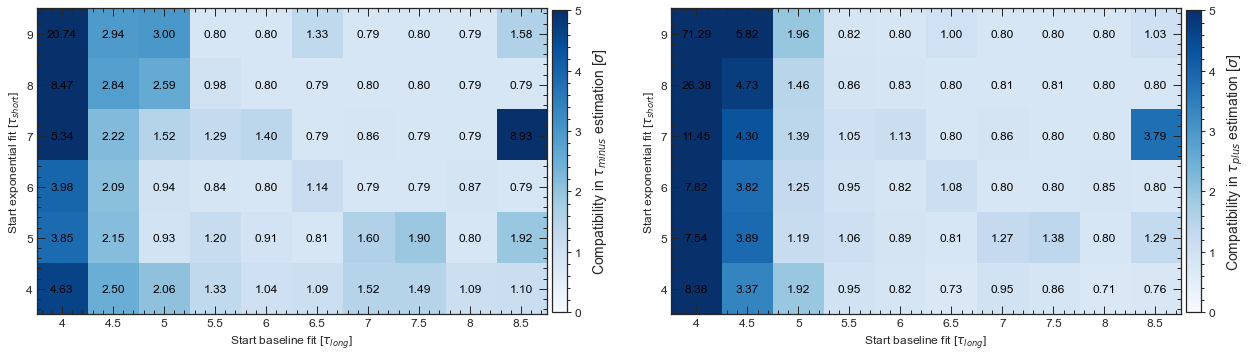

In [307]:
fig, ax = plt.subplots(1,2, figsize= (18,12))

max_, min_ = np.max(matrix), np.min(matrix)
im = ax[0].imshow(matrix, cmap='Blues', vmin = 0, vmax = 5)

# Show all ticks and label them with the respective list entries
labelsx = ['4','4.5','5','5.5','6','6.5','7','7.5','8','8.5']
labelsy = ['9','8','7','6','5','4']

ax[0].set_xticks(np.arange(len(labelsx)), labels=labelsx)
ax[0].set_yticks(np.arange(len(labelsy)), labels=labelsy)


# Loop over data dimensions and create text annotations.
for i in range(len(labelsy)):
    for j in range(len(labelsx)):
        text = ax[0].text(j, i, '%1.2f'%matrix[i, j],
                       ha="center", va="center", color="black",fontsize = 12)

ax[0].set_xlabel('Start baseline fit [$\\tau_{long}$]', fontsize = 12)
ax[0].set_ylabel('Start exponential fit [$\\tau_{short}$]', fontsize = 12)

ax[0].tick_params(which='major', width=1.0, length=8, direction='in', labelsize=12)

# Turn spines off and create white grid.
#ax[0].spines[:].set_visible(False)

cb = fig.colorbar(im, ax = ax[0],orientation = 'vertical', location = 'right', pad = 0.009, shrink =0.36)
cb.ax.set_ylabel('Compatibility in $\\tau_{minus}$ estimation [$\sigma$]', fontsize = 14, labelpad=10)
cb.ax.tick_params(which='major', width=1.0, length=4, direction='out', labelsize=12)
cb.ax.tick_params(which='minor', width=1.0, length=3, direction='out', labelsize=12)

cb.ax.minorticks_on()

#cb.ax[0].set_yticks(np.arange(0,0.06))

max_, min_ = np.max(matrix2), np.min(matrix2)
im = ax[1].imshow(matrix2, cmap='Blues', vmin = 0, vmax = 5)


# Show all ticks and label them with the respective list entries
labelsx = ['4','4.5','5','5.5','6','6.5','7','7.5','8','8.5']
labelsy = ['9','8','7','6','5','4']

ax[1].set_xticks(np.arange(len(labelsx)), labels=labelsx)
ax[1].set_yticks(np.arange(len(labelsy)), labels=labelsy)


# Loop over data dimensions and create text annotations.
for i in range(len(labelsy)):
    for j in range(len(labelsx)):
        text = ax[1].text(j, i, '%1.2f'%matrix2[i, j],
                       ha="center", va="center", color="black", fontsize = 12)

ax[1].set_xlabel('Start baseline fit [$\\tau_{long}$]', fontsize = 12)
ax[1].set_ylabel('Start exponential fit [$\\tau_{short}$]', fontsize = 12)

ax[1].tick_params(which='major', width=1.0, length=8, direction='in', labelsize=12)

# Turn spines off and create white grid.
#ax[1].spines[:].set_visible(False)

cb = fig.colorbar(im, ax = ax[1],orientation = 'vertical', location = 'right', pad = 0.009, shrink =0.36)
cb.ax.set_ylabel('Compatibility in $\\tau_{plus}$ estimation [$\sigma$]', fontsize = 14, labelpad=10)
cb.ax.tick_params(which='major', width=1.0, length=4, direction='out', labelsize=12)
cb.ax.tick_params(which='minor', width=1.0, length=3, direction='out', labelsize=12)

cb.ax.minorticks_on()

fig.tight_layout()
#fig.savefig("matrix.png", dpi = 400)
plt.show()

In [125]:
tree4 = ur.open('root_files/double_exp_3_new_norebin.root:exp_4')
tree5 = ur.open('root_files/double_exp_3_new_norebin.root:exp_5')
tree6 = ur.open('root_files/double_exp_3_new_norebin.root:exp_6')
tree7 = ur.open('root_files/double_exp_3_new_norebin.root:exp_7')
tree8 = ur.open('root_files/double_exp_3_new_norebin.root:exp_8')
tree9 = ur.open('root_files/double_exp_3_new_norebin.root:exp_9')

In [146]:
from numba import njit, prange,jit

@jit(parallel = True,forceobj=True)
def efficiency(data):
    counter = np.zeros(10)
    for i in prange(0,10):
        for j in prange(1000):
            if data['delta_tau_minus'].array()[j,i] < 3 and data['delta_tau_plus'].array()[j,i] < 3 and data['delta_A_minus'].array()[j,i] < 3 and data['delta_tau_plus'].array()[j,i] < 3:
                counter[i] = counter[i] + 1 
    return counter

In [147]:
count4 = efficiency(tree4)
count5 = efficiency(tree5)
count6 = efficiency(tree6)
count7 = efficiency(tree7)
count8 = efficiency(tree8)
count9 = efficiency(tree9)

In [148]:
df = pd.DataFrame([count4,count5,count6,count7,count8,count9])


In [151]:
tree4 = ur.open('root_files/double_exp_1_new_norebin.root:exp_4')
tree5 = ur.open('root_files/double_exp_1_new_norebin.root:exp_5')
tree6 = ur.open('root_files/double_exp_1_new_norebin.root:exp_6')
tree7 = ur.open('root_files/double_exp_1_new_norebin.root:exp_7')
tree8 = ur.open('root_files/double_exp_1_new_norebin.root:exp_8')
tree9 = ur.open('root_files/double_exp_1_new_norebin.root:exp_9')


count4 = efficiency(tree4)
count5 = efficiency(tree5)
count6 = efficiency(tree6)
count7 = efficiency(tree7)
count8 = efficiency(tree8)
count9 = efficiency(tree9)

df = pd.DataFrame([count4,count5,count6,count7,count8,count9])

np.savetxt('eff_1week.csv', df)

In [138]:
def error(N_sel, N_tot = 1000):
    sigma = N_sel/N_tot * np.sqrt(1/N_tot + 1 /N_sel)
    return sigma 

In [91]:
tau_short, tau_long, ratio, efficiency = np.loadtxt('efficiency.txt', unpack = True, skiprows=1)

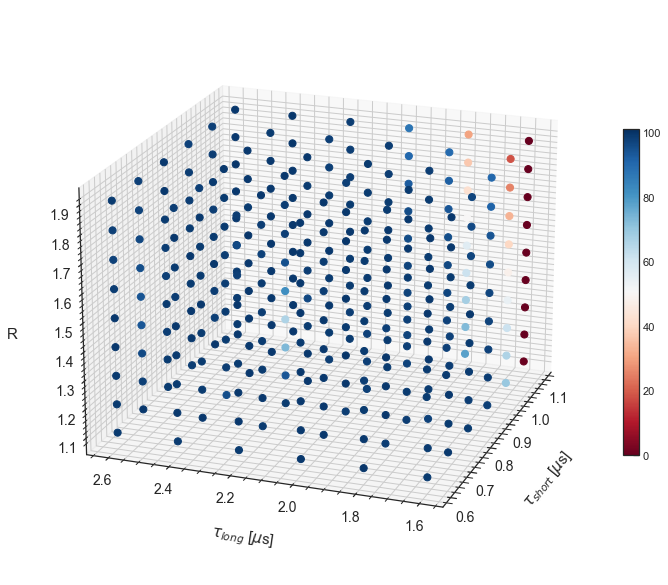

In [115]:
fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(111, projection='3d')

cmap = mpl.cm.get_cmap('RdBu')
Z = efficiency
sctt = ax.scatter3D(tau_short, tau_long, ratio, c = Z, 
            cmap = cmap, marker = 'o', s = 50, alpha = 1, vmax = 101)

ax.set_xlabel("$\\tau_{short}$ [$\mu$s]", fontsize = 15, labelpad = 20)
ax.set_ylabel("$\\tau_{long}$ [$\mu$s]", fontsize = 15, labelpad = 20)
ax.set_zlabel("R", fontsize = 15, labelpad = 20)


set_ticks(ax, 0.1,0.2)

clb = fig.colorbar(sctt, ax = ax,pad = 0.027, shrink=0.47, norm=mpl.colors.LogNorm(vmin=Z.min(), vmax=Z.max()+10))
clb.ax.yaxis.set_major_locator(MultipleLocator(20))

clb.ax.set_ylim(0, 101)

ax.view_init(20, 200)
fig.tight_layout()

plt.show()